In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('events.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], errors = 'coerce')
#df["storage"] = df["storage"].astype('category')

In [3]:
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['hour'] = df['timestamp'].dt.hour

Ordenamos primero respecto al tiempo y luego con un sort in place ordenamos respecto a las personas.
De esta forma nos quedan todos los logs de una misma persona juntos y ordenados respecto al tiempo

In [4]:
df.sort_values(by=['timestamp']).sort_values(by=['person'], inplace = True)

In [5]:
df['timediff'] = df['timestamp'].diff()
df['timediff'] = df['timediff'].dt.total_seconds()

df['newperson']= df['person'].apply(lambda x: int(x, 16))
df['newperson'] = df['newperson'].diff()
df['newperson'] = (df['newperson'] > 0)

Text(0.5,0,'diff')

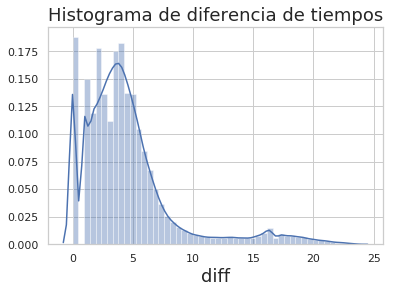

In [6]:
minidf = df.loc[(df['newperson'] == False) & (df['timediff'])]["timediff"]
minidf = np.log2(minidf)
g = sns.distplot(minidf)
g.set_title("Histograma de diferencia de tiempos", fontsize=18)
g.set_xlabel("diff",fontsize=18)


In [7]:
maxtime = 16368

In [8]:
df['viewed_product'] = (df['event'] == 'viewed product')
df['brand_listing'] = (df['event'] == 'brand listing')
df['visited_site'] = (df['event'] == 'visited site')
df['ad_campaign_hit'] = (df['event'] == 'ad campaign hit')
df['generic_listing'] = (df['event'] == 'generic listing')
df['searched_products'] = (df['event'] == 'searched products')
df['search_engine_hit'] = (df['event'] == 'search engine hit')
df['checkout'] = (df['event'] == 'checkout')
df['staticpage'] = (df['event'] == 'staticpage')
df['conversion'] = (df['event'] == 'conversion')
df['lead'] = (df['event'] == 'lead')
df['ad_url_model'] = ((df['url'].str.count('/') == 3) & (df['url'].str.contains('comprar')))
df['ad_url_brand'] = ((df['url'].str.count('/') == 2) & (df['url'].str.contains('comprar')))

In [9]:
df['newentry'] = ((df['timediff'] > maxtime) | (df['newperson']))
df['entry'] = df['newentry'].cumsum()

In [10]:
df['already_buyed'] = (df['conversion'] > 0)
df['already_buyed'] = df.groupby('person')['already_buyed'].cumsum()
df['already_buyed'] = (df['already_buyed'] > 0) & (df['already_buyed'].shift(1) > 0)
df['first_convertion'] = (df['event'] == 'conversion') & (df['already_buyed'] == False)

In [11]:
def primero(serie):
    lista = []
    for i in serie:
        if not pd.isnull(i):
            lista.append(i)
            break
    if lista:
        return lista.pop(0)
    return np.nan

def listar(serie):
    lista = []
    for i in serie:
        if not pd.isnull(i):
            lista.append(i)
    if lista:
        return lista
    return []

dict1 = ({'timestamp':primero, 'person':primero, 'sku':listar, 'model':listar, 'condition':listar,'storage':primero, 'color':listar, 'skus':listar, 
          'search_term':listar, 'staticpage':'sum','campaign_source':primero, 'search_engine':primero, 'channel':primero, 'new_vs_returning':primero,
          'city':primero, 'region':primero, 'country':primero, 'device_type':primero, 'screen_resolution':primero, 'operating_system_version':primero, 
          'browser_version':primero, 'day_of_week':primero, 'month':primero,'hour':primero, 'viewed_product':'sum', 'brand_listing':'sum',
          'visited_site':'sum', 'ad_campaign_hit':'sum', 'generic_listing':'sum','searched_products':'sum', 'search_engine_hit':'sum', 'checkout':'sum', 
          'conversion':'sum','lead':'sum', 'ad_url_model':'sum', 'ad_url_brand':'sum', 'newperson':primero})

entrydf = df.groupby('entry').agg(dict1)

In [12]:
def calcular_retencion(df):
    if df['conversion'] > 1:
        return 'multiple_conversions'
    
    if df['conversion'] > 0:
        return 'conversion'
    
    if df['checkout'] > 0:
        return 'checkout'
    
    if df['lead'] > 0:
        return 'lead'
    
    if df['searched_products'] > 0:
        return 'searched_products'
    
    if ((df['viewed_product'] > 0) & (df['ad_url_model'] == 0)) | (df['viewed_product'] > 1):
        return 'viewed_product'
    
    if ((df['brand_listing'] > 0) & (df['ad_url_brand'] == 0)) | (df['brand_listing'] > 1):
        return 'brand_listing'
    
    if df['generic_listing'] > 0:
        return 'generic_listing'
    
    if df['search_engine_hit'] > 0:
        return 'search_engine_hit'
    
    if df['visited_site'] > 0:
        return 'visited_site'
    
    return 'ad_campaing_hit' #el default es esto porque por algun motivo algunos logs que solo hacian ad_campaing_hit se quedaban sin esta columna
    
entrydf['retention'] = entrydf.apply(calcular_retencion, axis=1).astype('category')

In [13]:
entrydf

,model,search_engine,screen_resolution,ad_campaign_hit,viewed_product,ad_url_brand,staticpage,newperson,conversion,checkout,...,country,search_term,generic_listing,person,lead,color,new_vs_returning,sku,search_engine_hit,retention
entry,,,,,,,,,,,,,,,,,,,,,
0,"[iPhone 5s, iPhone 5s]",NaN,360x640,1.00,1.00,0.00,0.00,False,0.00,1.00,...,Brazil,[],0.00,0004b0a2,0.00,"[Cinza espacial, Cinza espacial]",New,"[2694.0, 2694.0]",0.00,checkout
1,"[Samsung Galaxy S8, Samsung Galaxy S8]",NaN,360x640,1.00,1.00,0.00,0.00,True,0.00,1.00,...,Brazil,[],0.00,0006a21a,0.00,"[Dourado, Dourado]",New,"[15338.0, 15338.0]",0.00,checkout
2,[Motorola Moto Z Play],Google,1920x1080,1.00,1.00,0.00,0.00,True,0.00,0.00,...,Brazil,[],1.00,000a54b2,0.00,[Preto],New,[12661.0],1.00,viewed_product
3,"[iPhone 7 Plus, iPhone 6S, iPhone 6S, iPhone 6...",Google,1920x1080,1.00,18.00,0.00,0.00,False,0.00,1.00,...,Brazil,[],4.00,000a54b2,0.00,"[Dourado, Cinza espacial, Cinza espacial, Cinz...",Returning,"[10254.0, 6581.0, 6579.0, 6580.0, 6581.0, 6580...",1.00,checkout
4,"[iPhone 4G, iPhone 4G, iPhone 4G, iPhone 4G, i...",Google,1366x768,0.00,32.00,0.00,0.00,True,0.00,2.00,...,Brazil,[],0.00,00184bf9,0.00,"[Preto, Preto, Preto, Preto, Preto, Preto, Pre...",New,"[102.0, 2716.0, 2751.0, 2709.0, 87.0, 101.0, 8...",2.00,checkout
5,"[iPhone 5c, iPhone 5c, iPhone 5c, iPhone 5c, i...",NaN,1366x768,0.00,4.00,0.00,0.00,False,0.00,1.00,...,Brazil,[],0.00,00184bf9,0.00,"[Azul, Branco, Branco, Branco, Branco]",Returning,"[3635.0, 3647.0, 3648.0, 213.0, 213.0]",0.00,checkout
6,[iPhone 5c],NaN,NaN,0.00,0.00,0.00,0.00,False,0.00,1.00,...,NaN,[],0.00,00184bf9,0.00,[Branco],NaN,[3649.0],0.00,checkout
7,"[Samsung Galaxy J5, Samsung Galaxy J5, Samsung...",Google,360x640,2.00,2.00,0.00,0.00,True,0.00,1.00,...,Brazil,[],0.00,0019c395,0.00,"[Preto, Preto, Preto]",New,"[6356.0, 6356.0, 6356.0]",2.00,checkout
8,[iPhone 7],Google,1366x768,0.00,1.00,0.00,0.00,True,0.00,0.00,...,Brazil,[],0.00,001bb7eb,0.00,[Preto Matte],New,[9930.0],1.00,viewed_product
